In [1]:
### SETUP ###
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from SCRIPTS.config import *
from SCRIPTS.dataprep import prepare_data
from SCRIPTS.models import BrainStateClassifier
from SCRIPTS.train import train_and_evaluate
from SCRIPTS.cross_validation_experiments import run_baseline_cross_validation

# Visualization setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Verify data files exist
print(f"  Raw fNIRS: {COMBINED_FNIRS}")
print(f"  Scattering: {COMBINED_SCATTERING}")
assert Path(COMBINED_FNIRS).exists(), f"fNIRS data not found at {COMBINED_FNIRS}"
assert Path(COMBINED_SCATTERING).exists(), f"Scattering data not found at {COMBINED_SCATTERING}"


  Raw fNIRS: /Users/judesack/Neurospectrum_Creativity/DATA/PREPARED_FNIRS_DATA/combined_fnirs_data.csv
  Scattering: /Users/judesack/Neurospectrum_Creativity/DATA/SCATTERING_COEFFICIENTS/combined_scattering_data.csv


In [2]:
### CONFIGURATION ###

# Train baseline MLP on raw fNIRS? T/F
TRAIN_FNIRS_BASELINE = False

# Train baseline MLP on scattering? T/F
TRAIN_SCATTERING_BASELINE = False

# Run cross-validation experiments? T/F
RUN_CROSS_VALIDATION = True

# Number of CV trials (set to 5)
CV_TRIALS = 5


In [3]:
### BASELINE MLP - RAW FNIRS ###

if TRAIN_FNIRS_BASELINE:
    print("\n=== TRAINING ON RAW FNIRS DATA ===")
    
    print("\n--- Subject Withholding ---")
    train_loader, test_loader = prepare_data(
        data_path=COMBINED_FNIRS,
        feature_prefix="node_",
        include_metadata=False,
        split_type="subject" 
    )
    
    fnirs_model = BrainStateClassifier(input_dim=48)
    model, preds, labels, metrics = train_and_evaluate(
        train_loader=train_loader,
        test_loader=test_loader,
        model=fnirs_model,
        num_epochs=DEFAULT_EPOCHS
    )

    print("\n--- Time Withholding ---")
    train_loader, test_loader = prepare_data(
        data_path=COMBINED_FNIRS,
        feature_prefix="node_",
        include_metadata=False,
        split_type="time" 
    )
    
    fnirs_model = BrainStateClassifier(input_dim=48)
    model, preds, labels, metrics = train_and_evaluate(
        train_loader=train_loader,
        test_loader=test_loader,
        model=fnirs_model,
        num_epochs=DEFAULT_EPOCHS
    )
else:
    print("✓ Skipping raw fNIRS baseline training")

✓ Skipping raw fNIRS baseline training


In [4]:
### BASELINE MLP - SCATTERING ###

if TRAIN_SCATTERING_BASELINE:
    print("\n=== TRAINING ON SCATTERING COEFFICIENTS ===")

    print("\n--- Subject Withholding ---")
    train_loader, test_loader = prepare_data(
        data_path=COMBINED_SCATTERING,
        feature_prefix="feature_",
        include_metadata=False,
        split_type="subject"
    )
    
    scattering_model = BrainStateClassifier(input_dim=768)
    model_subject, preds_subject, labels_subject, metrics_subject = train_and_evaluate(
        train_loader=train_loader,
        test_loader=test_loader,
        model=scattering_model,
        num_epochs=DEFAULT_EPOCHS
    )
    
    print("\n--- Time Withholding ---")
    train_loader, test_loader = prepare_data(
        data_path=COMBINED_SCATTERING,
        feature_prefix="feature_",
        include_metadata=False,
        split_type="time" 
    )
    
    scattering_model = BrainStateClassifier(input_dim=768)
    model_time, preds_time, labels_time, metrics_time = train_and_evaluate(
        train_loader=train_loader,
        test_loader=test_loader,
        model=scattering_model,
        num_epochs=DEFAULT_EPOCHS
    )
else:
    print("✓ Skipping scattering baseline training")

✓ Skipping scattering baseline training



=== CROSS-VALIDATION EXPERIMENTS (5 trials) ===

--- RAW FNIRS CROSS-VALIDATION ---

SUBJECT SPLIT:

=== Baseline MLP Trial 1/5 (subject split) ===

Split: subject — train 100800, test 21600
Using cpu
Started training...
Epoch 10/100: Loss=0.1164, Acc=95.81%
Epoch 20/100: Loss=0.0872, Acc=96.95%
Epoch 30/100: Loss=0.0765, Acc=97.34%
Epoch 40/100: Loss=0.0697, Acc=97.56%
Epoch 50/100: Loss=0.0660, Acc=97.71%
Epoch 60/100: Loss=0.0607, Acc=97.94%
Epoch 70/100: Loss=0.0566, Acc=98.07%
Epoch 80/100: Loss=0.0569, Acc=98.07%
Epoch 90/100: Loss=0.0548, Acc=98.15%
Epoch 100/100: Loss=0.0519, Acc=98.19%

Test Set Results:
              precision    recall  f1-score   support

        Rest      0.601     0.802     0.687     12000
      Improv      0.343     0.279     0.307      4800
       Scale      0.302     0.105     0.156      4800

    accuracy                          0.531     21600
   macro avg      0.415     0.395     0.384     21600
weighted avg      0.477     0.531     0.485     2160

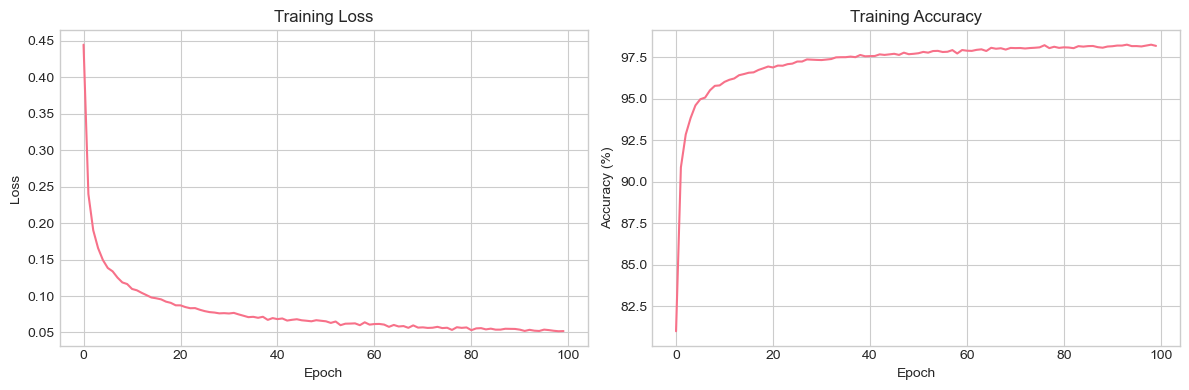

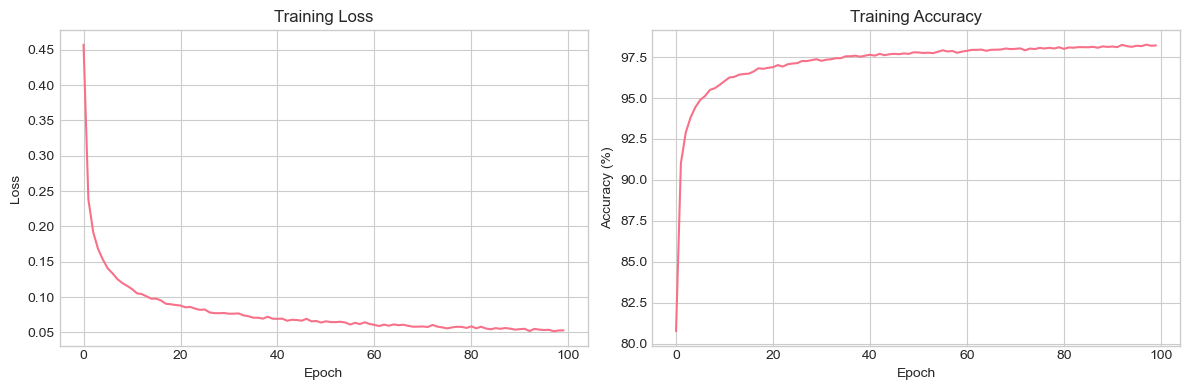

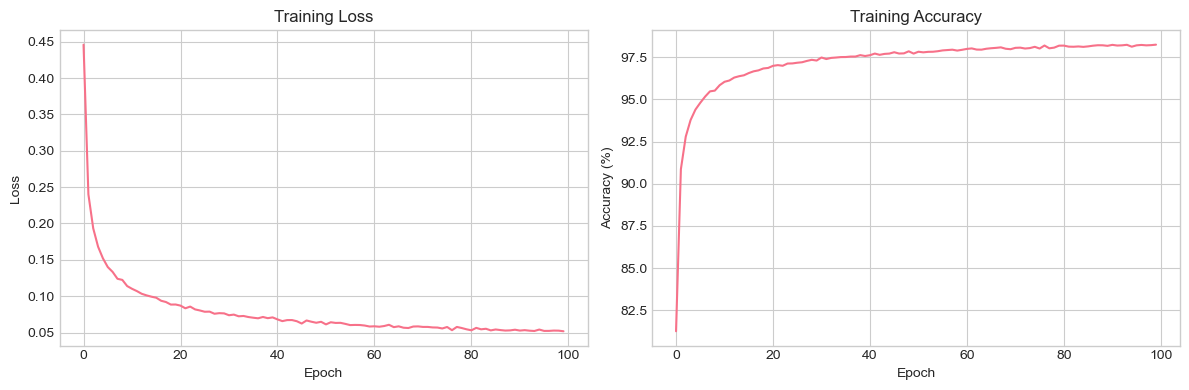

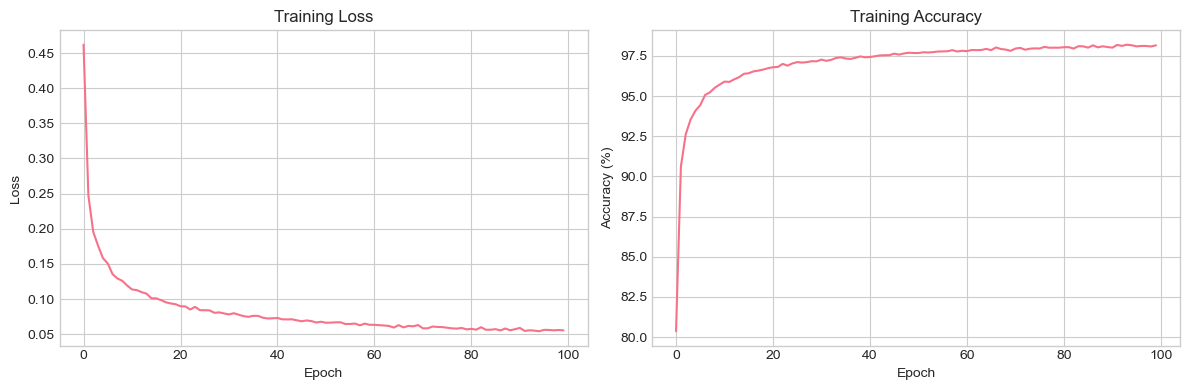

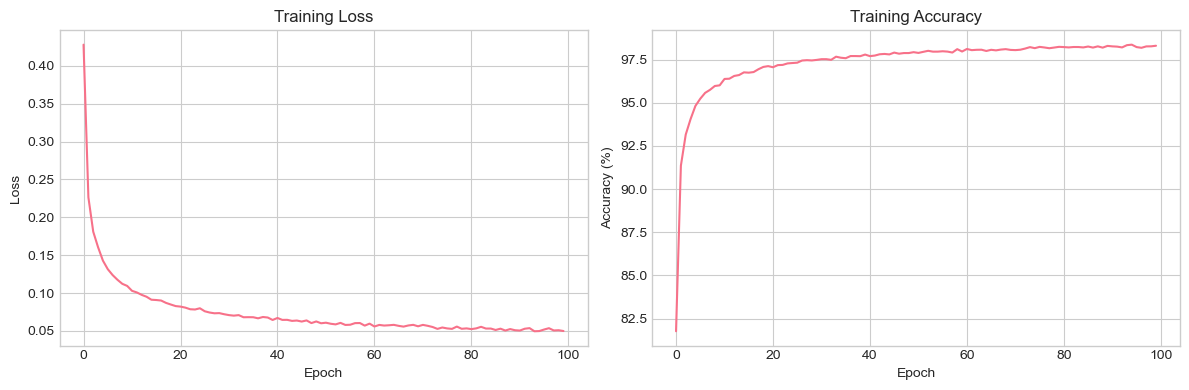

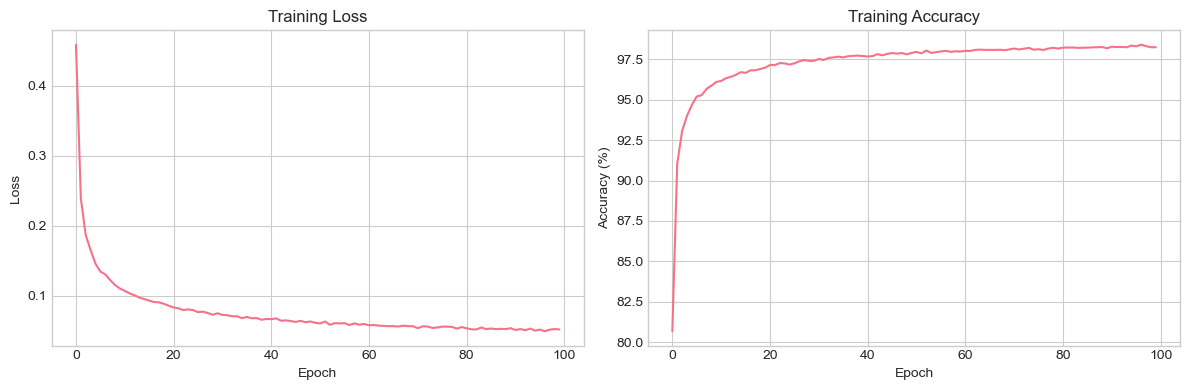

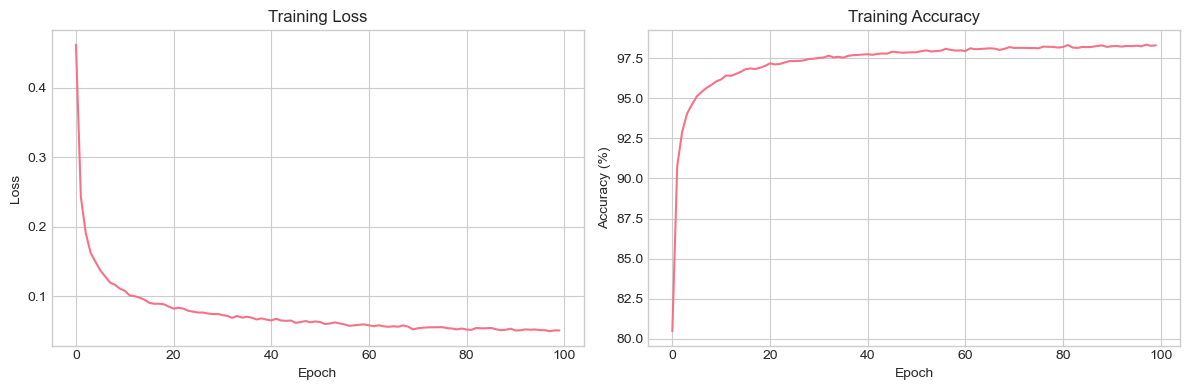

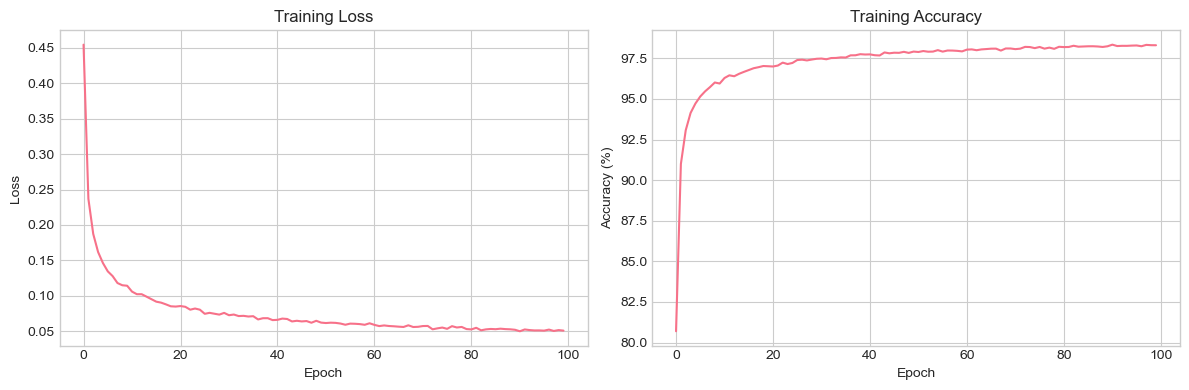

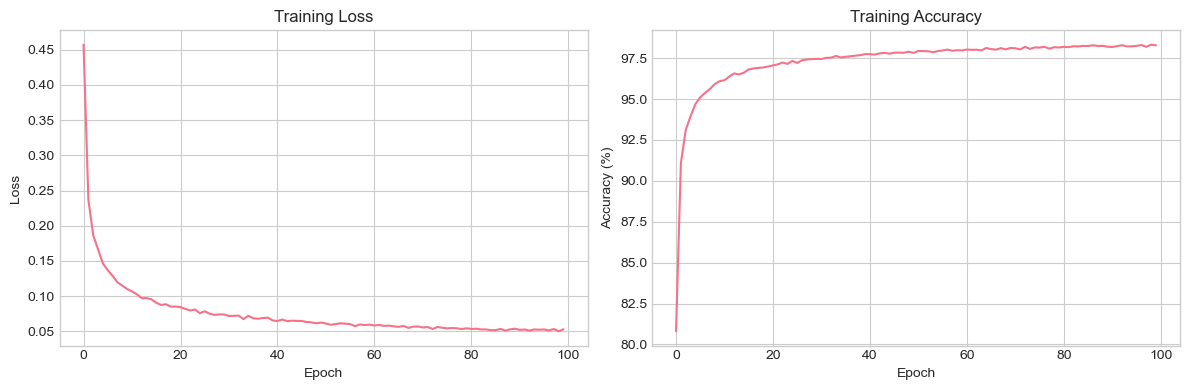

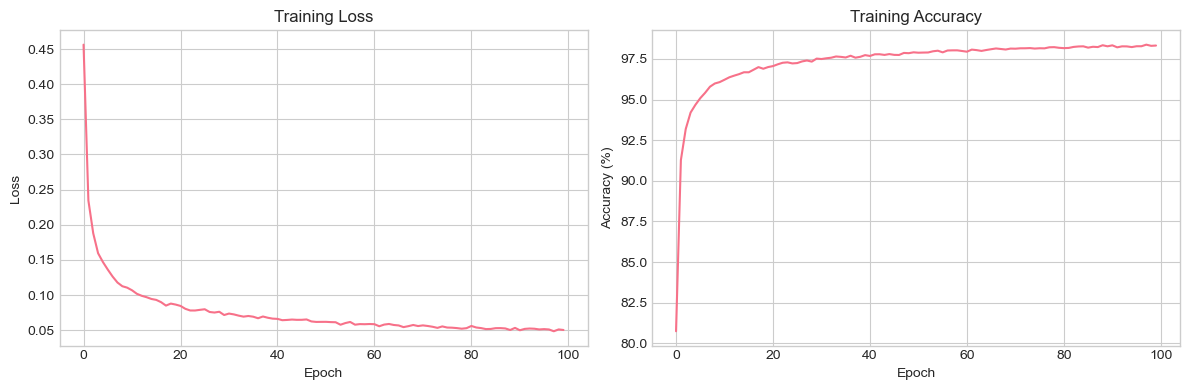

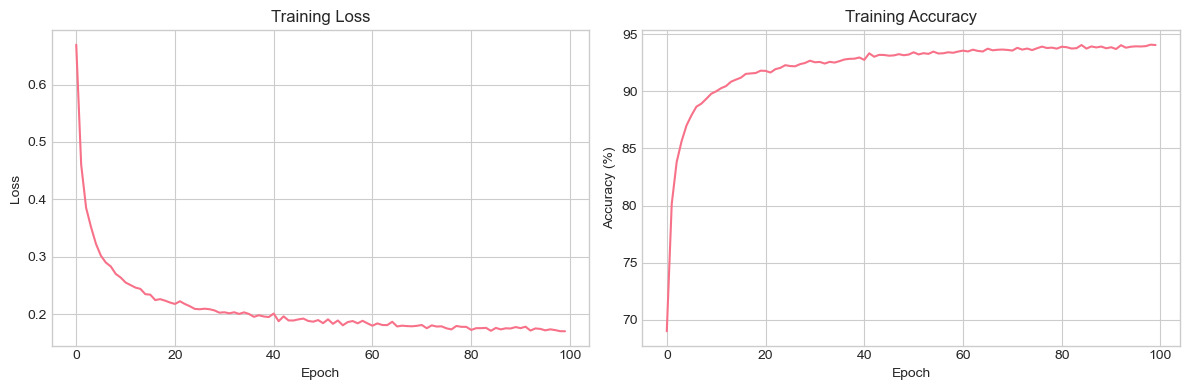

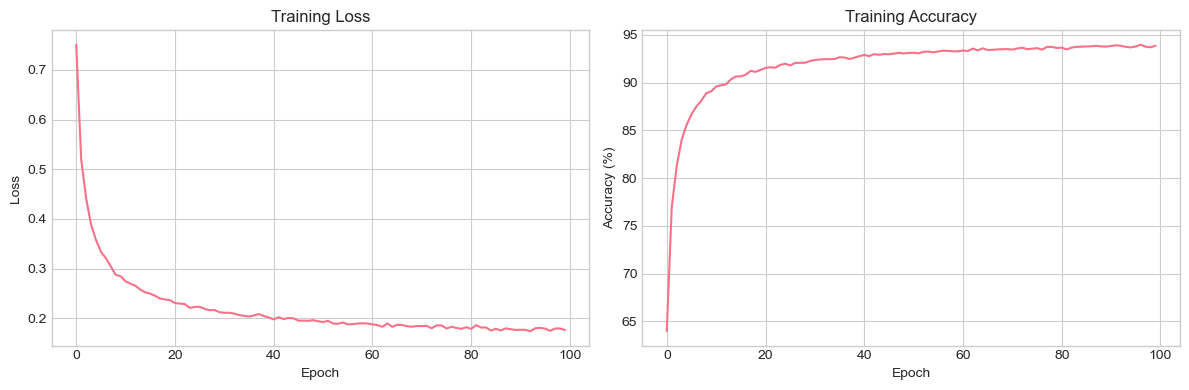

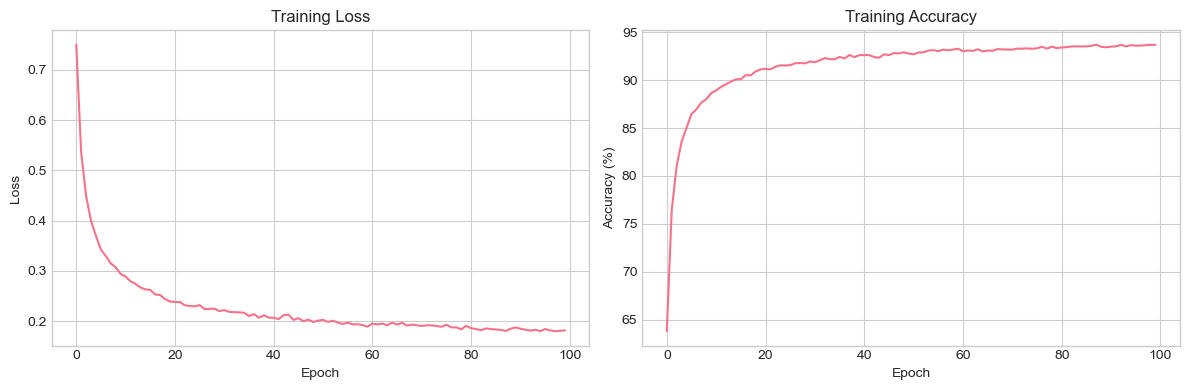

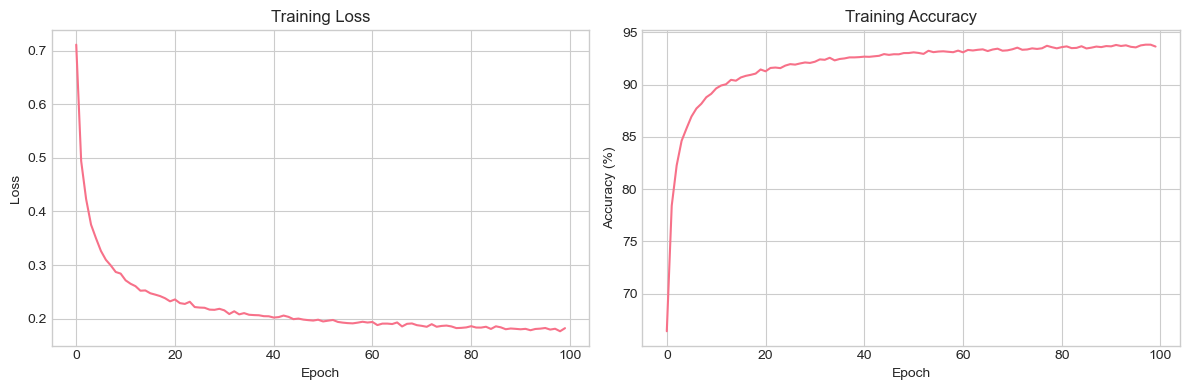

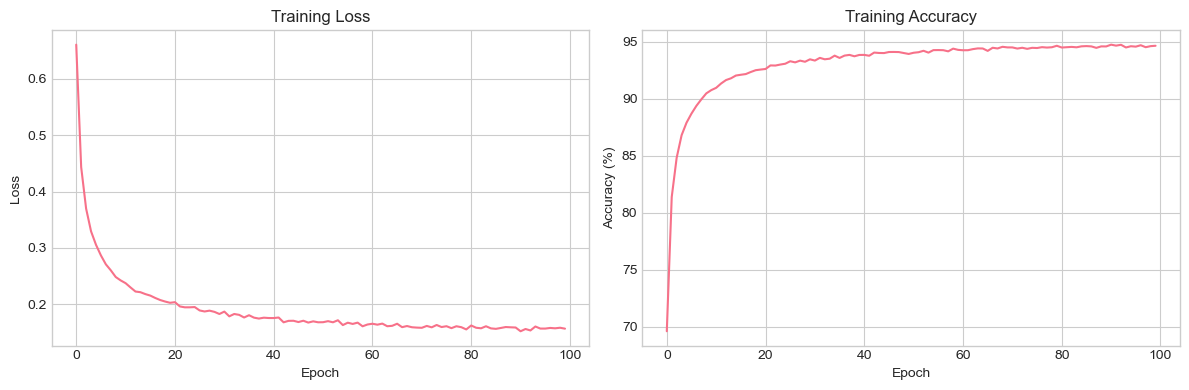

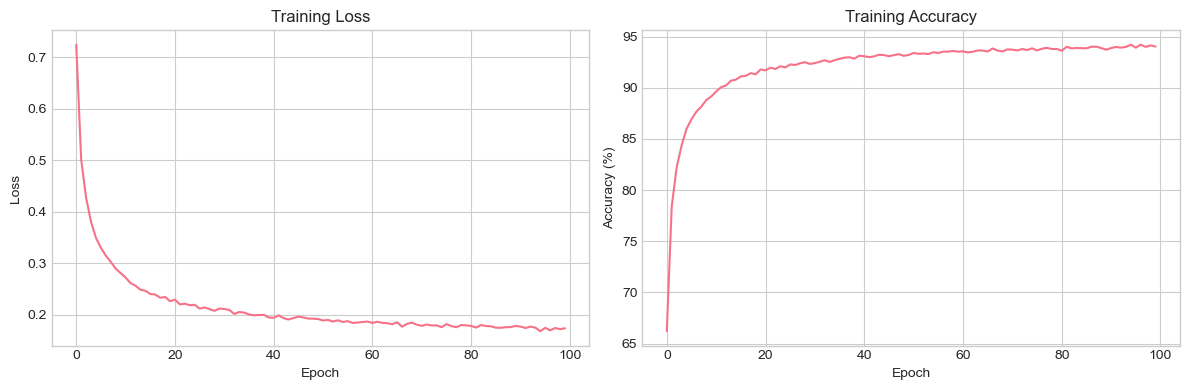

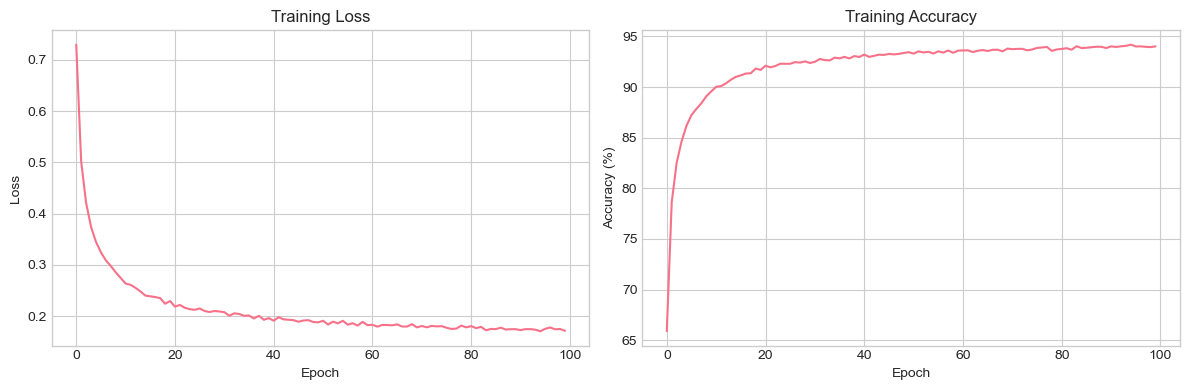

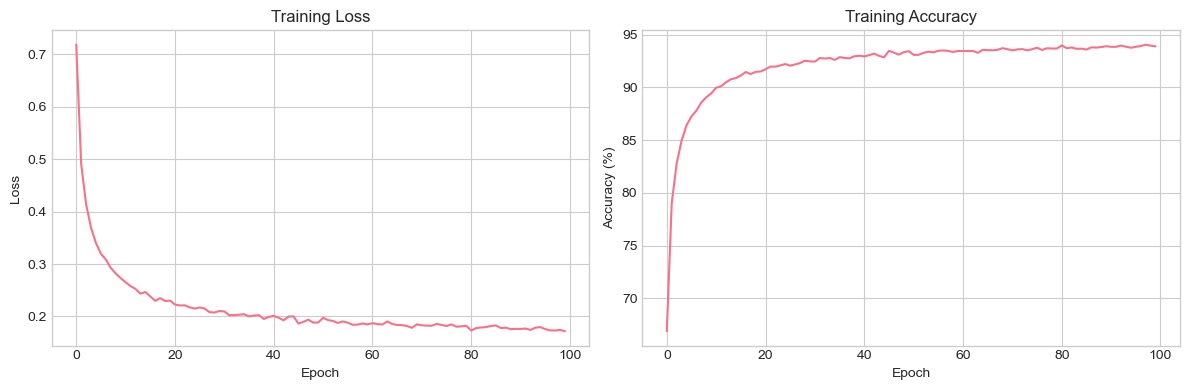

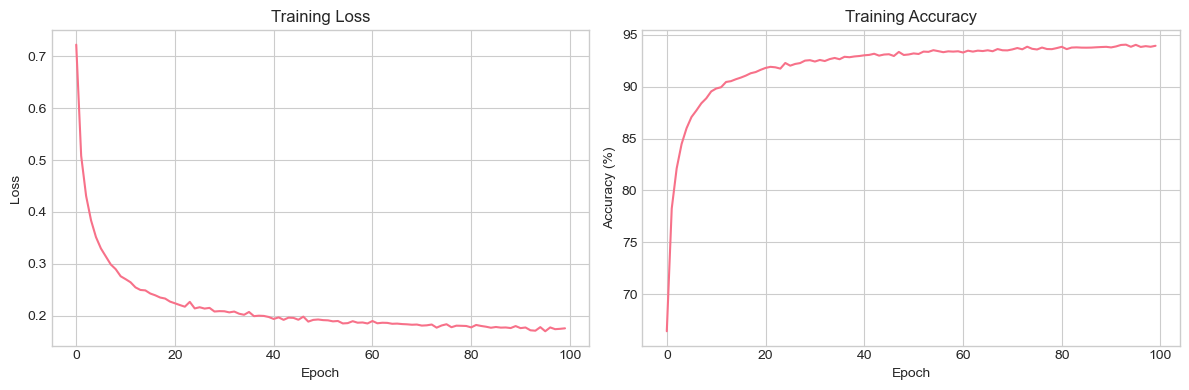

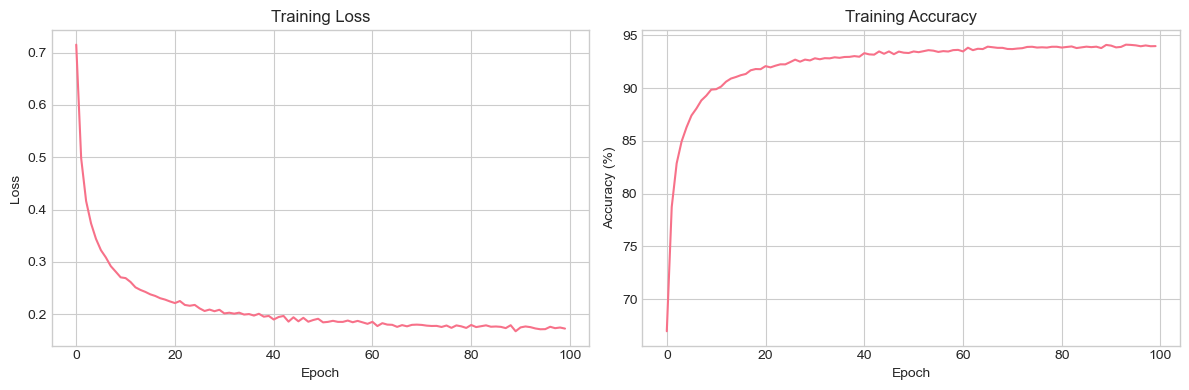

In [5]:
### CROSS-VALIDATION EXPERIMENTS ###

if RUN_CROSS_VALIDATION:
    print(f"\n=== CROSS-VALIDATION EXPERIMENTS ({CV_TRIALS} trials) ===")
    
    print("\n--- RAW FNIRS CROSS-VALIDATION ---")
    fnirs_results = {}
    
    for split_type in ["subject", "time"]:
        print(f"\n{split_type.upper()} SPLIT:")
        fnirs_results[split_type] = run_baseline_cross_validation(
            data_path=COMBINED_FNIRS,
            feature_prefix="node_",
            split_type=split_type,
            num_trials=CV_TRIALS, 
            input_dim=48
        )

    print("\n--- SCATTERING CROSS-VALIDATION ---")
    scattering_results = {}
    
    for split_type in ["subject", "time"]:
        print(f"\n{split_type.upper()} SPLIT:")
        scattering_results[split_type] = run_baseline_cross_validation(
            data_path=COMBINED_SCATTERING,
            feature_prefix="feature_",
            split_type=split_type,
            num_trials=CV_TRIALS,
            input_dim=768
        )

    cv_results = {
        'fnirs': fnirs_results,
        'scattering': scattering_results
    }
    
    save_path = BASELINE_RESULTS_DIR / 'baseline_cv_results.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(cv_results, f)
    
    print(f"\n✓ Results saved to {save_path}")
    
    #Summary
    print("\n=== CROSS-VALIDATION SUMMARY ===")
    print(f"Raw fNIRS (subject): {fnirs_results['subject']['mean_accuracy']:.2%} ± {fnirs_results['subject']['std_accuracy']:.2%}")
    print(f"Raw fNIRS (time): {fnirs_results['time']['mean_accuracy']:.2%} ± {fnirs_results['time']['std_accuracy']:.2%}")
    print(f"Scattering (subject): {scattering_results['subject']['mean_accuracy']:.2%} ± {scattering_results['subject']['std_accuracy']:.2%}")
    print(f"Scattering (time): {scattering_results['time']['mean_accuracy']:.2%} ± {scattering_results['time']['std_accuracy']:.2%}")

else:
    # Load existing results
    cv_file = BASELINE_RESULTS_DIR / 'baseline_cv_results.pkl'
    
    if cv_file.exists():
        with open(cv_file, 'rb') as f:
            cv_results = pickle.load(f)
        
        print(f"✓ Loaded existing cross-validation results from {cv_file}")
        
        fnirs_results = cv_results['fnirs']
        scattering_results = cv_results['scattering']
        
        print("\n=== CROSS-VALIDATION SUMMARY ===")
        print(f"Raw fNIRS (subject): {fnirs_results['subject']['mean_accuracy']:.2%} ± {fnirs_results['subject']['std_accuracy']:.2%}")
        print(f"Raw fNIRS (time): {fnirs_results['time']['mean_accuracy']:.2%} ± {fnirs_results['time']['std_accuracy']:.2%}")
        print(f"Scattering (subject): {scattering_results['subject']['mean_accuracy']:.2%} ± {scattering_results['subject']['std_accuracy']:.2%}")
        print(f"Scattering (time): {scattering_results['time']['mean_accuracy']:.2%} ± {scattering_results['time']['std_accuracy']:.2%}")
    else:
        print("✓ No existing cross-validation results found")